In [110]:
from pandas import read_csv, DataFrame
from numpy.random import seed
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dense, Merge
from keras.layers.normalization import BatchNormalization
from keras import initializers, layers
from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import ReadStandardTimeFill as RSTF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [131]:
seed(1)

def Footprint(Input,N):
    model = Sequential()
    model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'sigmoid'))
    model.add(BatchNormalization())
    return(model)
    
def Weather(Input,N):
    model = Sequential()
    model.add(Dense(N, input_shape = (Input.shape[1],), activation = 'relu'))
    model.add(BatchNormalization())
    return(model)
    
def Concat(Inputs,N):
    model = Sequential()
    model.add(Merge(Inputs, mode = 'concat'))
    model.add(Dense(N, activation = 'relu',kernel_initializer=initializer))
#     model.add(Dense(2))
    return(model)
    
def Compile(model):
    model.add(Dense(1))
    callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model,callbacks)

class ReadStandardTimeFill:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        self.Master['fch4'] *= 1000
        self.TimeSteps=0
        
    def Scale(self,y_var,X1_vars,X2_vars=[]):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        if len(X2_vars)>0:
            X1 = self.Data[X1_vars]
            X1Standard = StandardScaler()
            self.X1Scaled= X1Standard.fit(X1)
            self.X1 = self.X1Scaled.transform(X1)
            Filling1 = self.Master[X1_vars]
            Filling1 = Filling1.interpolate().bfill()
            Filling1 = Filling1.interpolate().ffill()
            self.X1FillScaled= X1Standard.fit(Filling1)
            self.X1_fill = self.X1Scaled.transform(Filling1)
            
            X2 = self.Data[X2_vars]
            X2Standard = StandardScaler()
            self.X2Scaled= X2Standard.fit(X2)
            self.X2 = self.X2Scaled.transform(X2)
            Filling2 = self.Master[X2_vars]
            Filling2 = Filling2.interpolate().bfill()
            Filling2 = Filling2.interpolate().ffill()
            self.X2FillScaled= X2Standard.fit(Filling2)
            self.X2_fill = self.X2Scaled.transform(Filling2)
        else:
            X = self.Data[X1_vars]
            self.input_shape = len(X1_vars)
            XStandard = StandardScaler()
            self.XScaled= XStandard.fit(X)
            self.X = self.XScaled.transform(X)
            Filling = self.Master[X1_vars]
            Filling = Filling.interpolate().bfill()
            Filling = Filling.interpolate().ffill()
#             XStandard = StandardScaler()
            self.XFillScaled= XStandard.fit(Filling)
            self.X_fill = self.XScaled.transform(Filling)
        
cwd = os.getcwd()
params={}
params['Dpath'] = cwd+'/Illisarvik/'
RST = ReadStandardTimeFill(params['Dpath']+'ECData.csv')

# RST = ReadStandardTimeFill()

In [157]:
fp_vars = ['Sedge']#,'Grass','Shrub','Sparse','Water','Out_of_Basin']
wx_vars = ['VWC']#'wind_speed', 'PPFD_Avg', 'VPD', 'AirTC_Avg', 'VWC']
# print (fp_vars+wx_vars)
RST.Scale('fch4',fp_vars,wx_vars)
# print(RST.y)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Anaconda3\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


84.80674099192096 8.398412079793486
59.43791149674198 7.070345706280109
98.94580250025349 8.864408838896015
51.572716019652106 8.568783855714825
56.288740733639145 8.088633614987875
90.13158770399853 7.904845313189373
43.73196123461186 6.969967399487373
43.010244632178285 6.555804616876766
63.34569407547801 8.909685348872872
109.24925425193433 8.342234993634035


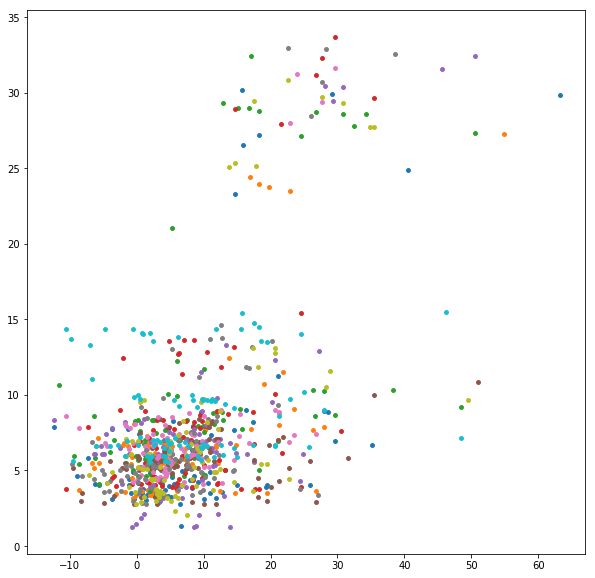

70.05206536404087


In [158]:

plt.figure(figsize=(10,10))
Score = []
nCap=5
for i in range(10):
    seed(i)
    X1_train,X1_test,X2_train,X2_test,y_train,y_test=train_test_split(RST.X1,RST.X2,RST.y, test_size=0.1)
    X1_train,X1_val,X2_train,X2_val,y_train,y_val=train_test_split(X1_train,X2_train,y_train, test_size=0.11)

    Fp = Footprint(X1_train,N=X1_train.shape[1]*nCap)
    Wt = Weather(X2_train,N=X2_train.shape[1]*nCap)
    FullModel = Concat([Fp,Wt],N=X1_train.shape[1]*2+X2_train.shape[1]*nCap)
    FullModel,callbacks = Compile(FullModel)
    FullModel.fit([X1_train,X2_train], y_train,
                  validation_data=([X1_test,X2_test], y_test), 
                  batch_size = 50, nb_epoch = 200,
                  verbose = 0,callbacks=callbacks)
    Yp = FullModel.predict([X1_val,X2_val],batch_size=100)
#     print()

    Yp = RST.YScaled.inverse_transform(Yp.reshape(-1,1))
    Yv = RST.YScaled.inverse_transform(y_val.reshape(-1,1))
    print(metrics.mean_squared_error(Yv,Yp),Yv.mean())
    Score.append(metrics.mean_squared_error(Yv,Yp))
    
    plt.scatter(Yv,Yp,s=15,label = 'Concated')
plt.show()
MSE = np.asanyarray(Score)
print(MSE.mean())

#old 34.37323956423951